In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Activation, RepeatVector, Permute, Multiply, Lambda, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import tensorflow.keras.backend as K

# Load data
df = pd.read_csv('Coffee_Stores_Data.csv')

# Preprocess and remove NaN values
df.dropna(inplace=True)

# Convert 'BusinessDate' to a datetime index
df['BusinessDate'] = pd.to_datetime(df['BusinessDate'])
df.set_index('BusinessDate', inplace=True)

# Feature engineering
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Weekday'] = df.index.weekday
df['Sales'] = df['SoldQuantity'] * 3  # Assuming a sales value to predict

# Selecting features and target
selected_features = ['SoldQuantity', 'ReceivedQuantity', 'LatestOrder', 'StockedOut']
X = df[selected_features]
y = df['Sales']

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Attention mechanism
def attention_mechanism(inputs):
    lstm_units = int(inputs.shape[2])
    attention = Dense(1, activation='tanh')(inputs)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(lstm_units)(attention)
    attention = Permute([2, 1])(attention)
    attention_output = Multiply()([inputs, attention])
    return attention_output

# Define the model using the functional API
inputs = Input(shape=(1, X_train.shape[2]))
lstm_out = LSTM(50, return_sequences=True)(inputs)
attention_out = attention_mechanism(lstm_out)
lstm_out_2 = LSTM(50)(attention_out)
output = Dense(1)(lstm_out_2)

# Compile the model
model = Model(inputs=[inputs], outputs=[output])
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model to the training data
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=1)

# Predictions
predictions = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, predictions)
print(f'Test MSE: {mse}')


Epoch 1/100
12472/12472 [==============================] - 57s 4ms/step - loss: 5.4381 - val_loss: 0.0228
Epoch 2/100
12472/12472 [==============================] - 59s 5ms/step - loss: 0.0579 - val_loss: 0.0018
Epoch 3/100
12472/12472 [==============================] - 67s 5ms/step - loss: 0.0422 - val_loss: 5.6072e-04
Epoch 4/100
12472/12472 [==============================] - 62s 5ms/step - loss: 0.0351 - val_loss: 7.0829e-04
Epoch 5/100
12472/12472 [==============================] - 55s 4ms/step - loss: 0.0301 - val_loss: 2.2851e-04
Epoch 6/100
12472/12472 [==============================] - 55s 4ms/step - loss: 0.0271 - val_loss: 4.9157e-04
Epoch 7/100
12472/12472 [==============================] - 55s 4ms/step - loss: 0.0250 - val_loss: 6.1757e-05
Epoch 8/100
12472/12472 [==============================] - 55s 4ms/step - loss: 0.0231 - val_loss: 3.1893e-04
Epoch 9/100
12472/12472 [==============================] - 55s 4ms/step - loss: 0.0217 - val_loss: 5.7638e-04
Epoch 10/100
12472

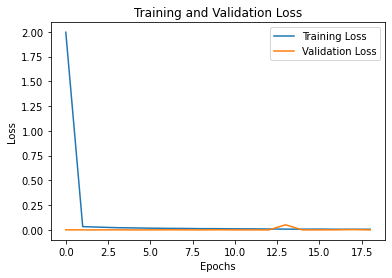

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

 I've added Bidirectional LSTM layers to capture patterns from both forward and backward states of the sequences.
(This allows the network to capture dependencies in both forward and backward directions in the sequence data, potentially improving the model's learning capacity.)

-Adjusted the batch size to 32 for more frequent updates.

-Included an EarlyStopping callback to prevent overfitting by stopping the training if the validation loss does not improve for 10 epochs.

-Changed the learning rate of the Adam optimizer to 0.001 for potentially better convergence.

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Activation, RepeatVector, Permute, Multiply, Lambda, Flatten, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# Load data
df = pd.read_csv('Coffee_Stores_Data.csv')

# Preprocess and remove NaN values
df.dropna(inplace=True)

# Convert 'BusinessDate' to a datetime index
df['BusinessDate'] = pd.to_datetime(df['BusinessDate'])
df.set_index('BusinessDate', inplace=True)

# Feature engineering
df['Month'] = df.index.month
df['Year'] = df.index.year

df['Sales'] = df['SoldQuantity'] * 3  # Assuming a sales value to predict

# Selecting features and target
selected_features = ['ReceivedQuantity', 'LatestOrder', 'StockedOut', 'Month', 'Year']
X = df[selected_features]
y = df['Sales']

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Attention mechanism
def attention_mechanism(inputs):
    lstm_units = int(inputs.shape[2])
    attention = Dense(1, activation='tanh')(inputs)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(lstm_units)(attention)
    attention = Permute([2, 1])(attention)
    attention_output = Multiply()([inputs, attention])
    return attention_output

# Define the model using the functional API
inputs = Input(shape=(1, X_train.shape[2]))
lstm_out = Bidirectional(LSTM(50, return_sequences=True))(inputs)
attention_out = attention_mechanism(lstm_out)
lstm_out_2 = Bidirectional(LSTM(50))(attention_out)
output = Dense(1)(lstm_out_2)

# Compile the model with adjustments in optimizer or loss
model = Model(inputs=[inputs], outputs=[output])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Add EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model with adjustments in epochs and batch_size
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

# Predictions
predictions = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, predictions)
print(f'Test MSE: {mse}')


Epoch 1/50
24943/24943 [==============================] - 119s 4ms/step - loss: 27.9347 - val_loss: 23.7198
Epoch 2/50
24943/24943 [==============================] - 126s 5ms/step - loss: 23.7104 - val_loss: 22.8171
Epoch 3/50
24943/24943 [==============================] - 110s 4ms/step - loss: 23.3197 - val_loss: 22.7614
Epoch 4/50
24943/24943 [==============================] - 117s 5ms/step - loss: 23.1017 - val_loss: 22.5746
Epoch 5/50
24943/24943 [==============================] - 152s 6ms/step - loss: 22.9031 - val_loss: 22.7186
Epoch 6/50
24943/24943 [==============================] - 226s 9ms/step - loss: 22.7231 - val_loss: 22.2230
Epoch 7/50
24943/24943 [==============================] - 223s 9ms/step - loss: 22.6151 - val_loss: 22.2194
Epoch 8/50
24943/24943 [==============================] - 222s 9ms/step - loss: 22.5253 - val_loss: 22.0196
Epoch 9/50
24943/24943 [==============================] - 218s 9ms/step - loss: 22.4605 - val_loss: 21.9140
Epoch 10/50
24943/24943 [===

In [22]:
X_test_array = X_test.reshape(-1, len(selected_features))

# Convert y_test to a NumPy array and flatten if needed
y_test_array = np.array(y_test).flatten()

# Create a DataFrame with true values, predicted values, and selected features
result_df = pd.DataFrame(X_test_array, columns=selected_features)
result_df['True Sales'] = y_test_array
result_df['Predicted Sales'] = predictions

In [23]:
result_df

,ReceivedQuantity,LatestOrder,StockedOut,Month,Year,True Sales,Predicted Sales
0,0.188119,0.608696,1.0,0.818182,0.0,33.0,34.675220
1,0.138614,0.391304,0.0,0.090909,1.0,3.0,4.147985
2,0.168317,0.652174,0.0,0.090909,1.0,12.0,15.390342
3,0.148515,0.521739,0.0,0.909091,0.0,6.0,6.851048
4,0.128713,0.000000,0.0,0.818182,0.0,0.0,-0.007157
...,...,...,...,...,...,...,...
249419,0.158416,0.478261,1.0,0.545455,0.0,18.0,17.172070
249420,0.133663,0.000000,0.0,0.636364,0.0,0.0,-0.012221
249421,0.168317,0.782609,0.0,0.636364,0.0,15.0,15.824021
249422,0.128713,0.521739,1.0,0.272727,1.0,3.0,6.137159


## Dropout in LSTM Layers
Dropout has been added to the LSTM layers (dropout=0.2). Dropout is a regularization technique where randomly selected neurons are ignored during training, which helps in preventing overfitting.

ReduceLROnPlateau Callback: The ReduceLROnPlateau callback is added along with EarlyStopping. This callback reduces the learning rate when a metric has stopped improving. In this case, it monitors the validation loss ('val_loss'), reducing the learning rate by a factor of 0.2 if there's no improvement in 5 epochs, with a minimum learning rate set to 0.0001.

#Changed Training Parameters: The training parameters have been adjusted, specifically the number of epochs is reduced to 20 (from 50 in the first code), and the batch size is increased to 64 (from 32).##

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Activation, RepeatVector, Permute, Multiply, Lambda, Flatten, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error

# Load data
df = pd.read_csv('Coffee_Stores_Data.csv')

# Preprocess and remove NaN values
df.dropna(inplace=True)

# Convert 'BusinessDate' to a datetime index
df['BusinessDate'] = pd.to_datetime(df['BusinessDate'])
df.set_index('BusinessDate', inplace=True)

# Feature engineering
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Sales'] = df['SoldQuantity'] * 3  # Assuming a sales value to predict

# Selecting features and target
selected_features = ['ReceivedQuantity', 'LatestOrder', 'StockedOut', 'Month', 'Year']
X = df[selected_features]
y = df['Sales']

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Attention mechanism
def attention_mechanism(inputs):
    lstm_units = int(inputs.shape[2])
    attention = Dense(1, activation='tanh')(inputs)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(lstm_units)(attention)
    attention = Permute([2, 1])(attention)
    attention_output = Multiply()([inputs, attention])
    return attention_output

# Define the model using the functional API with added dropout
inputs = Input(shape=(1, X_train.shape[2]))
lstm_out = Bidirectional(LSTM(50, return_sequences=True, dropout=0.2))(inputs)  # Added dropout
attention_out = attention_mechanism(lstm_out)
lstm_out_2 = Bidirectional(LSTM(50, dropout=0.2))(attention_out)  # Added dropout
output = Dense(1)(lstm_out_2)

# Compile the model
model = Model(inputs=[inputs], outputs=[output])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Add EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Fit the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=1, callbacks=[early_stopping, reduce_lr])

# Predictions
predictions = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, predictions)
print(f'Test MSE: {mse}')


Epoch 1/20
12472/12472 [==============================] - 90s 7ms/step - loss: 50.1681 - val_loss: 78.9875 - lr: 0.0010
Epoch 2/20
12472/12472 [==============================] - 74s 6ms/step - loss: 30.4708 - val_loss: 87.6903 - lr: 0.0010
Epoch 3/20
12472/12472 [==============================] - 64s 5ms/step - loss: 28.1976 - val_loss: 79.2058 - lr: 0.0010
Epoch 4/20
12472/12472 [==============================] - 74s 6ms/step - loss: 27.6304 - val_loss: 79.5329 - lr: 0.0010
Epoch 5/20
12472/12472 [==============================] - 72s 6ms/step - loss: 27.5418 - val_loss: 75.3420 - lr: 0.0010
Epoch 6/20
12472/12472 [==============================] - 69s 6ms/step - loss: 27.4514 - val_loss: 79.7319 - lr: 0.0010
Epoch 7/20
12472/12472 [==============================] - 73s 6ms/step - loss: 27.2753 - val_loss: 80.6127 - lr: 0.0010
Epoch 8/20
12472/12472 [==============================] - 78s 6ms/step - loss: 27.0881 - val_loss: 84.3497 - lr: 0.0010
Epoch 9/20
12472/12472 [================

## Features added : 
Increased LSTM Units: The units in the first Bidirectional LSTM layer are increased to 64 (from 50 in Code 1), and a second Bidirectional LSTM layer with 32 units is added.

Dense Layer Configuration Change: A Dense layer with 64 units and 'relu' activation is introduced before the final output layer, without the attention mechanism used in Code 1.

Change in Dropout Rate: The dropout rate in the first Bidirectional LSTM layer is set to 0.1 (compared to the 0.2 rate in Code 1 for dropout layers).

Different Optimizer: The optimizer is changed from Adam to Nadam ('nadam').

Adjustment in Early Stopping and ReduceLROnPlateau Callbacks:

EarlyStopping: The patience parameter is increased to 15 (from 10 in Code 1).
ReduceLROnPlateau: The factor is set to 0.1, patience to 10, and minimum learning rate to 0.00001.
Adjusted Training Parameters: The number of epochs is increased to 100 (from 50), the batch size is increased to 64 (from 32), and the validation split is increased to 0.25 (from 0.2).

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error

# Load data
df = pd.read_csv('Coffee_Stores_Data.csv')

# Preprocess and remove NaN values
df.dropna(inplace=True)

# Convert 'BusinessDate' to a datetime index and perform feature engineering
df['BusinessDate'] = pd.to_datetime(df['BusinessDate'])
df.set_index('BusinessDate', inplace=True)
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Sales'] = df['SoldQuantity'] * 3  # Assuming a sales value to predict

# Selecting features and target
selected_features = ['ReceivedQuantity', 'LatestOrder', 'StockedOut', 'Month', 'Year']
X = df[selected_features]
y = df['Sales']

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define a more complex LSTM model with attention mechanism
inputs = Input(shape=(1, X_train.shape[2]))
x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.1))(inputs)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dense(64, activation='relu')(x)
x = Flatten()(x)
output = Dense(1)(x)

# Compile the model with a different optimizer
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='nadam', loss='mean_squared_error')

# Add EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.25, verbose=1, callbacks=[early_stopping, reduce_lr])

# Predictions and Evaluation
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Test MSE: {mse}')


Epoch 1/100
11692/11692 [==============================] - 64s 5ms/step - loss: 34.5741 - val_loss: 51.6279 - lr: 0.0010
Epoch 2/100
11692/11692 [==============================] - 54s 5ms/step - loss: 25.2602 - val_loss: 50.2780 - lr: 0.0010
Epoch 3/100
11692/11692 [==============================] - 57s 5ms/step - loss: 24.7781 - val_loss: 49.2713 - lr: 0.0010
Epoch 4/100
11692/11692 [==============================] - 57s 5ms/step - loss: 24.5946 - val_loss: 48.1954 - lr: 0.0010
Epoch 5/100
11692/11692 [==============================] - 57s 5ms/step - loss: 24.4321 - val_loss: 53.0323 - lr: 0.0010
Epoch 6/100
11692/11692 [==============================] - 56s 5ms/step - loss: 24.3482 - val_loss: 50.5583 - lr: 0.0010
Epoch 7/100
11692/11692 [==============================] - 56s 5ms/step - loss: 24.3591 - val_loss: 44.7952 - lr: 0.0010
Epoch 8/100
11692/11692 [==============================] - 57s 5ms/step - loss: 24.1998 - val_loss: 51.6329 - lr: 0.0010
Epoch 9/100
11692/11692 [=======

In [46]:
##This model didnt perfome well

#Complexity of the Model: The increased complexity (more LSTM units and layers) might not have been necessary for this dataset, potentially leading to overfitting or inefficient learning.


#Removal of Attention Mechanism: The absence of the attention mechanism, which was present in Code 1, might have reduced the model's ability to focus on important features in the sequence data.

#Change in Optimizer: The switch to Nadam might not have been as effective as Adam for this particular problem and dataset.

#Training Dynamics: The increased number of epochs and changes in batch size and learning rate might have influenced the training, but not in a way that benefits the model's performance.

In [30]:
X_test_array = X_test.reshape(-1, len(selected_features))

# Convert y_test to a NumPy array and flatten if needed
y_test_array = np.array(y_test).flatten()

# Create a DataFrame with true values, predicted values, and selected features
result_df = pd.DataFrame(X_test_array, columns=selected_features)
result_df['True Sales'] = y_test_array
result_df['Predicted Sales'] = predictions
result_df

,ReceivedQuantity,LatestOrder,StockedOut,Month,Year,True Sales,Predicted Sales
0,0.188119,0.608696,1.0,0.818182,0.0,33.0,24.541569
1,0.138614,0.391304,0.0,0.090909,1.0,3.0,4.801142
2,0.168317,0.652174,0.0,0.090909,1.0,12.0,9.632602
3,0.148515,0.521739,0.0,0.909091,0.0,6.0,4.307131
4,0.128713,0.000000,0.0,0.818182,0.0,0.0,0.576154
...,...,...,...,...,...,...,...
249419,0.158416,0.478261,1.0,0.545455,0.0,18.0,8.765635
249420,0.133663,0.000000,0.0,0.636364,0.0,0.0,0.602673
249421,0.168317,0.782609,0.0,0.636364,0.0,15.0,9.479501
249422,0.128713,0.521739,1.0,0.272727,1.0,3.0,11.067169


## Changes in LSTM Layers Configuration:

Increased number of units in the first Bidirectional LSTM layer from 50 to 64.
Added a second Bidirectional LSTM layer with 32 units.
Increased dropout rate in the first LSTM layer from 0.2 to 0.15.
Additional Dropout Layer: An extra dropout layer with a rate of 0.15 is added after the second LSTM layer.

Dense Layer Before Output: A Dense layer with 64 units and 'relu' activation is introduced before the final output layer. This is a change from the attention mechanism used in Code 1.

Changed Optimizer and Learning Rate: The optimizer is changed from Adam to Nadam, with an adjusted learning rate of 0.0005.

Modification in Callbacks:

EarlyStopping: Increased patience from 10 to 20.
ReduceLROnPlateau: Adjusted the parameters, including the factor to 0.1, patience to 7, and minimum learning rate to 0.00001.
Adjustment in Training Parameters: Increased the batch size to 128 and validation split to 0.25, while keeping the number of epochs at 50.##

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error

# Load data
df = pd.read_csv('Coffee_Stores_Data.csv')

# Preprocess and remove NaN values
df.dropna(inplace=True)

# Convert 'BusinessDate' to a datetime index and perform feature engineering
df['BusinessDate'] = pd.to_datetime(df['BusinessDate'])
df.set_index('BusinessDate', inplace=True)
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Sales'] = df['SoldQuantity'] * 3  # Assuming a sales value to predict

# Selecting features and target
selected_features = ['ReceivedQuantity', 'LatestOrder', 'StockedOut', 'Month', 'Year']
X = df[selected_features]
y = df['Sales']

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define a more complex LSTM model with attention mechanism
inputs = Input(shape=(1, X_train.shape[2]))
x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.15))(inputs)  # Increased dropout
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dropout(0.15)(x)  # Additional dropout layer
x = Dense(64, activation='relu')(x)
x = Flatten()(x)
output = Dense(1)(x)

# Compile the model with a different optimizer and learning rate
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer=Nadam(learning_rate=0.0005), loss='mean_squared_error')  # Adjusted learning rate

# Add EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)  # Increased patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, min_lr=0.00001)  # Adjusted parameters

# Fit the model with an adjusted batch size
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.25, verbose=1, callbacks=[early_stopping, reduce_lr])  # Adjusted batch size

# Predictions and Evaluation
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Test MSE: {mse}')


Epoch 1/50
5846/5846 [==============================] - 47s 7ms/step - loss: 55.1928 - val_loss: 96.2659 - lr: 5.0000e-04
Epoch 2/50
5846/5846 [==============================] - 38s 6ms/step - loss: 31.1717 - val_loss: 145.1408 - lr: 5.0000e-04
Epoch 3/50
5846/5846 [==============================] - 36s 6ms/step - loss: 28.0635 - val_loss: 118.0420 - lr: 5.0000e-04
Epoch 4/50
5846/5846 [==============================] - 37s 6ms/step - loss: 27.2843 - val_loss: 113.2483 - lr: 5.0000e-04
Epoch 5/50
5846/5846 [==============================] - 36s 6ms/step - loss: 26.8590 - val_loss: 99.4146 - lr: 5.0000e-04
Epoch 6/50
5846/5846 [==============================] - 37s 6ms/step - loss: 26.5588 - val_loss: 103.1740 - lr: 5.0000e-04
Epoch 7/50
5846/5846 [==============================] - 39s 7ms/step - loss: 26.4659 - val_loss: 95.9484 - lr: 5.0000e-04
Epoch 8/50
5846/5846 [==============================] - 38s 7ms/step - loss: 26.3416 - val_loss: 91.9516 - lr: 5.0000e-04
Epoch 9/50
5846/5846

In [42]:
# It basic lstm + attention model had performed better 
#Increased Model Complexity: The additional LSTM layer and Dense layer might have made the model too complex for the data, potentially leading to overfitting despite the increased dropout rates.
#Optimizer and Learning Rate Changes: The use of Nadam with a lower learning rate might not have been as effective as the original configuration in Code 1.
#Training Parameters: The increased batch size and validation split could have impacted the training dynamics, potentially leading to less effective learning.

## Changes in lstm 
Conv1D Layer: A Conv1D layer is introduced at the beginning of the model. Conv1D layers are used for extracting features from sequences, which can be effective in understanding temporal patterns.

Increased LSTM Units and Additional Dropout: The number of units in the first Bidirectional LSTM layer is increased to 80, and in the second layer to 40. Additionally, the dropout rate is set to 0.25 in both LSTM layers to help prevent overfitting.

Dense Layer with Regularization: A Dense layer with 100 units and 'relu' activation is added, which also includes L1 and L2 regularization (kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)). Regularization is a technique to reduce overfitting by penalizing large weights.

Batch Normalization: A Batch Normalization layer is added, which can help in stabilizing and speeding up the training process by normalizing the input layer by re-centering and re-scaling.

Increased Dropout Rate: The dropout rate after the Dense layer is increased to 0.3.

Changed Optimizer, Learning Rate, and Early Stopping Parameters:

The optimizer is changed to Nadam with a learning rate of 0.0005.
The EarlyStopping patience is increased to 30, and ReduceLROnPlateau patience to 10, with a minimum learning rate of 0.00001.
Adjusted Training Parameters: The number of epochs is substantially increased to 350, the batch size is set to 64, and the validation split is increased to 0.3.##

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Conv1D, BatchNormalization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from sklearn.metrics import mean_squared_error

# Load data
df = pd.read_csv('Coffee_Stores_Data.csv')

# Preprocess and remove NaN values
df.dropna(inplace=True)

# Convert 'BusinessDate' to a datetime index and perform feature engineering
df['BusinessDate'] = pd.to_datetime(df['BusinessDate'])
df.set_index('BusinessDate', inplace=True)
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Sales'] = df['SoldQuantity'] * 3

# Selecting features and target
selected_features = ['ReceivedQuantity', 'LatestOrder', 'StockedOut', 'Month', 'Year']
X = df[selected_features]
y = df['Sales']

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the LSTM model with advanced architecture
inputs = Input(shape=(1, X_train.shape[2]))
x = Conv1D(filters=32, kernel_size=1, activation='relu')(inputs)  # Conv1D layer for sequence feature extraction
x = Bidirectional(LSTM(80, return_sequences=True, dropout=0.25))(x)
x = Bidirectional(LSTM(40, return_sequences=False, dropout=0.25))(x)
x = Dense(100, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)  # Regularization
x = BatchNormalization()(x)  # Batch Normalization
x = Dropout(0.3)(x)
output = Dense(1)(x)

# Compile the model
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer=Nadam(learning_rate=0.0005), loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)

# Fit the model
history = model.fit(X_train, y_train, epochs=350, batch_size=64, validation_split=0.3, verbose=1, callbacks=[early_stopping, reduce_lr])

# Predictions and Evaluation
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Test MSE: {mse}')


Epoch 1/350
10913/10913 [==============================] - 107s 9ms/step - loss: 35.3001 - val_loss: 24.0305 - lr: 5.0000e-04
Epoch 2/350
10913/10913 [==============================] - 78s 7ms/step - loss: 27.6431 - val_loss: 28.8501 - lr: 5.0000e-04
Epoch 3/350
10913/10913 [==============================] - 78s 7ms/step - loss: 26.8610 - val_loss: 23.8886 - lr: 5.0000e-04
Epoch 4/350
10913/10913 [==============================] - 78s 7ms/step - loss: 26.7226 - val_loss: 25.8867 - lr: 5.0000e-04
Epoch 5/350
10913/10913 [==============================] - 81s 7ms/step - loss: 26.4597 - val_loss: 23.5229 - lr: 5.0000e-04
Epoch 6/350
10913/10913 [==============================] - 79s 7ms/step - loss: 26.1609 - val_loss: 24.0493 - lr: 5.0000e-04
Epoch 7/350
10913/10913 [==============================] - 79s 7ms/step - loss: 26.1188 - val_loss: 23.5032 - lr: 5.0000e-04
Epoch 8/350
10913/10913 [==============================] - 79s 7ms/step - loss: 26.0336 - val_loss: 23.1326 - lr: 5.0000e-04

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Conv1D, BatchNormalization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from sklearn.metrics import mean_squared_error

# Load data
df = pd.read_csv('Coffee_Stores_Data.csv')

# Preprocess and remove NaN values
df.dropna(inplace=True)

# Convert 'BusinessDate' to a datetime index and perform feature engineering
df['BusinessDate'] = pd.to_datetime(df['BusinessDate'])
df.set_index('BusinessDate', inplace=True)
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Sales'] = df['SoldQuantity'] * 3

# Selecting features and target
selected_features = ['ReceivedQuantity', 'LatestOrder', 'StockedOut', 'Month', 'Year']
X = df[selected_features]
y = df['Sales']

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the LSTM model with advanced architecture
inputs = Input(shape=(1, X_train.shape[2]))
x = Conv1D(filters=32, kernel_size=1, activation='relu')(inputs)  # Conv1D layer for sequence feature extraction
x = Bidirectional(LSTM(80, return_sequences=True, dropout=0.25))(x)
x = Bidirectional(LSTM(40, return_sequences=False, dropout=0.25))(x)
x = Dense(100, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)  # Regularization
x = BatchNormalization()(x)  # Batch Normalization
x = Dropout(0.3)(x)
output = Dense(1)(x)

# Compile the model
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer=Nadam(learning_rate=0.0005), loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)

# Fit the model
history = model.fit(X_train, y_train, epochs=350, batch_size=64, validation_split=0.3, verbose=1, callbacks=[early_stopping, reduce_lr])

# Predictions and Evaluation
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Test MSE: {mse}')


In [34]:
X_test_array = X_test.reshape(-1, len(selected_features))

# Convert y_test to a NumPy array and flatten if needed
y_test_array = np.array(y_test).flatten()

# Create a DataFrame with true values, predicted values, and selected features
result_df = pd.DataFrame(X_test_array, columns=selected_features)
result_df['True Sales'] = y_test_array
result_df['Predicted Sales'] = predictions

In [35]:
result_df

,ReceivedQuantity,LatestOrder,StockedOut,Month,Year,True Sales,Predicted Sales
0,0.188119,0.608696,1.0,0.818182,0.0,33.0,34.346584
1,0.138614,0.391304,0.0,0.090909,1.0,3.0,4.761110
2,0.168317,0.652174,0.0,0.090909,1.0,12.0,15.574140
3,0.148515,0.521739,0.0,0.909091,0.0,6.0,7.206759
4,0.128713,0.000000,0.0,0.818182,0.0,0.0,0.103714
...,...,...,...,...,...,...,...
249419,0.158416,0.478261,1.0,0.545455,0.0,18.0,16.932339
249420,0.133663,0.000000,0.0,0.636364,0.0,0.0,0.229206
249421,0.168317,0.782609,0.0,0.636364,0.0,15.0,15.711812
249422,0.128713,0.521739,1.0,0.272727,1.0,3.0,5.905665


Model Complexity: The increased complexity of the model might not be necessary or beneficial for the given dataset. Sometimes, simpler models perform better on certain types of data.

Overfitting/Underfitting Balance: While efforts were made to prevent overfitting (like increased dropout and regularization), it's possible that the balance between bias and variance was not optimally achieved.

Training Dynamics: The increased number of epochs and changes in batch size and learning rate might have influenced the training process, but not necessarily in a way that enhances performance for this specific dataset.

# Fine Tunning by regularization of Input data


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler  # Import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Conv1D, BatchNormalization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from sklearn.metrics import mean_squared_error

# Load data
df = pd.read_csv('Coffee_Stores_Data.csv')

# Preprocess and remove NaN values
df.dropna(inplace=True)

# Convert 'BusinessDate' to a datetime index and perform feature engineering
df['BusinessDate'] = pd.to_datetime(df['BusinessDate'])
df.set_index('BusinessDate', inplace=True)
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Sales'] = df['SoldQuantity'] * 3

# Selecting features and target
selected_features = ['ReceivedQuantity', 'LatestOrder', 'StockedOut', 'Month', 'Year']
X = df[selected_features]
y = df['Sales']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected features
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the LSTM model with advanced architecture
inputs = Input(shape=(1, X_train.shape[2]))
x = Conv1D(filters=32, kernel_size=1, activation='relu')(inputs)  # Conv1D layer for sequence feature extraction
x = Bidirectional(LSTM(80, return_sequences=True, dropout=0.25))(x)
x = Bidirectional(LSTM(40, return_sequences=False, dropout=0.25))(x)
x = Dense(100, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)  # Regularization
x = BatchNormalization()(x)  # Batch Normalization
x = Dropout(0.3)(x)
output = Dense(1)(x)

# Compile the model
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer=Nadam(learning_rate=0.0005), loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)

# Fit the model
history = model.fit(X_train, y_train, epochs=35, batch_size=128, validation_split=0.3, verbose=1, callbacks=[early_stopping, reduce_lr])

# Predictions and Evaluation
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Test MSE: {mse}')


Epoch 1/35
5457/5457 [==============================] - 85s 14ms/step - loss: 31.4948 - val_loss: 23.5189 - lr: 5.0000e-04
Epoch 2/35
5457/5457 [==============================] - 78s 14ms/step - loss: 25.3353 - val_loss: 23.0020 - lr: 5.0000e-04
Epoch 3/35
5457/5457 [==============================] - 77s 14ms/step - loss: 25.0205 - val_loss: 22.8409 - lr: 5.0000e-04
Epoch 4/35
5457/5457 [==============================] - 78s 14ms/step - loss: 24.8534 - val_loss: 22.8669 - lr: 5.0000e-04
Epoch 5/35
5457/5457 [==============================] - 77s 14ms/step - loss: 24.6445 - val_loss: 22.6513 - lr: 5.0000e-04
Epoch 6/35
5457/5457 [==============================] - 78s 14ms/step - loss: 24.4780 - val_loss: 22.5557 - lr: 5.0000e-04
Epoch 7/35
5457/5457 [==============================] - 77s 14ms/step - loss: 24.4073 - val_loss: 23.2719 - lr: 5.0000e-04
Epoch 8/35
5457/5457 [==============================] - 80s 15ms/step - loss: 24.2632 - val_loss: 22.9199 - lr: 5.0000e-04
Epoch 9/35
5457/